In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import xml.etree.ElementTree as ET
import os

import torch

In [2]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
model = torch.load('./best_model.pth')  # load the model

In [4]:
class test_bones_dataset(Dataset):
    
    CLASSES = ['fracture', 'background']
    
    def __init__(
            self, 
            images_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.images_fps = images_dir
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):

        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']

        return image
        
    def __len__(self):
        return len(self.images_fps)

In [5]:
path_to_valid_imgs = "xray/arm fracture/validation/"  # path to test imgs

images_valid = sorted([path_to_valid_imgs + filename for filename in os.listdir(path_to_valid_imgs)])

In [6]:
import albumentations as albu
import segmentation_models_pytorch as smp

def get_validation_augmentation():
    test_transform = [
        albu.Resize(224,224),
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['fracture']
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

test_dataset = test_bones_dataset(
    images_valid, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
showset = test_bones_dataset(images_valid, classes=CLASSES)

In [7]:
img = "xray/arm fracture/validation/3.jpg"


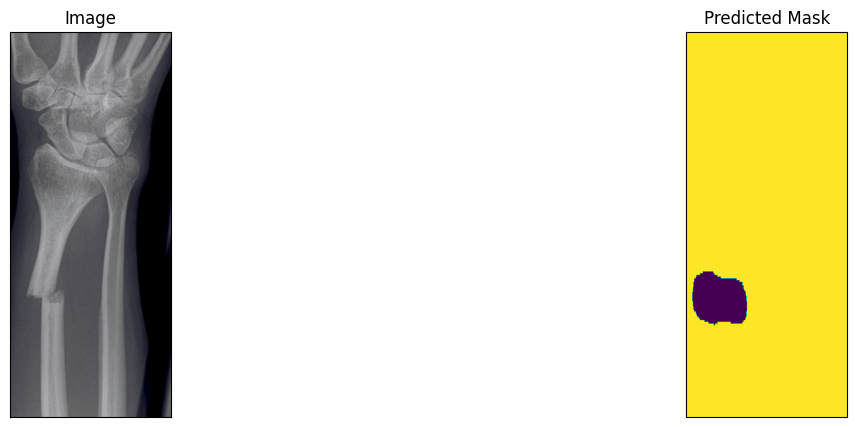

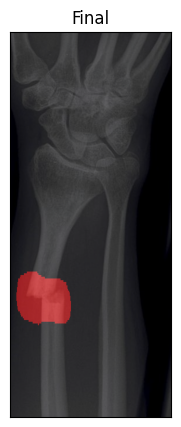

In [8]:
image_vis = showset[3]
image = test_dataset[3]
h, w = image_vis.shape[:2]

model.eval()
with torch.no_grad():
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    out = model(x_tensor).squeeze().cpu().numpy().round()
    out = cv2.resize(out, (w, h)).astype('uint8')

visualize(
        image=image_vis, 
        predicted_mask=out
    )

_, thresh = cv2.threshold(out, 0.5, 255, cv2.THRESH_BINARY_INV)
pure = np.zeros(thresh.shape).astype('uint8')
out3 = cv2.merge((thresh, pure, pure))

res = cv2.addWeighted(image_vis,0.5,out3,0.5,0)
visualize(final=res)